# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")

import time
import os
import copy

## GPU 설정

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [81]:
print(device)

cpu


## 데이터 로드 및 확인

In [82]:
# import wget

# # !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# # !unzip hymenoptera_data -d .


# link = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
# wget.download(link, out=".")

#해당 부분은 노트북에선 힘들고, 서버에서 다시 테스트 해봐야할 것 같음

## 전처리 설정

In [83]:
data_transforms = {"train":transforms.Compose([transforms.RandomResizedCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
                   "val": transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
                       }

In [84]:
# print(os.getcwd())

data_dir = "G:\내 드라이브\공부\code\python_code\_2021_project\_torch_2021_12/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ["train","val"]}
# print(image_datasets)

dataloaders = {x : DataLoader(image_datasets[x], batch_size=4,shuffle=True,num_workers=0) for x in ["train","val"]}
dataset_sizes = {x : len(image_datasets[x]) for x in ["train","val"] }

# print(dataset_sizes)
# print(dataloaders["train"])
class_names = image_datasets["train"].classes

In [85]:
print(class_names)

['ants', 'bees']


## 사전훈련된 모델 로드

In [86]:
model_ft = models.resnet18(pretrained=True)

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [87]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [88]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)

## 손실함수와 옵티마이저

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 1e-3, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [90]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=7, gamma=0.1)

## 모델 학습

- 학습 함수 정의

In [91]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc =0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch : {epoch}/{num_epochs-1}")
        print("-"*10)
        for phase in ["train","val"]:
            print(f"epoch : {epoch} phase : {phase}")
            if phase =="train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            # print("dataloaders")
            # print(dataloaders)
            # print("phase")
            # print(phase)
            # print(next(iter(dataloaders[phase])))
            # print(list(dataloaders[phase]))
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) 
                labels = labels.to(device) 
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase =="train"):
                    outputs = model(inputs) 
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    if phase =="train":
                        loss.backward()
                        optimizer.step()
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds ==labels.data)
            if phase =="train":
                scheduler.step()
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f"{phase} Loss : {epoch_loss:.4f} Accuracy : {epoch_acc:.4f}")
        
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapse = time.time()-since 
    print(f"Training time : {time_elapse//60:.0f}m {time_elapse%60:.0f}s")
    print(f"Best Validation Accuracy : {best_acc:4f}")

    model.load_state_dict(best_model_wts)
    return model

In [92]:
model_ft=train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=3)

Epoch : 0/2
----------
epoch : 0 phase : train
train Loss : 0.5776 Accuracy : 0.7131
epoch : 0 phase : val
val Loss : 0.2485 Accuracy : 0.9020

Epoch : 1/2
----------
epoch : 1 phase : train
train Loss : 0.4255 Accuracy : 0.8443
epoch : 1 phase : val
val Loss : 0.2338 Accuracy : 0.9281

Epoch : 2/2
----------
epoch : 2 phase : train
train Loss : 0.4504 Accuracy : 0.8033
epoch : 2 phase : val
val Loss : 0.3200 Accuracy : 0.8889

Training time : 2m 55s
Best Validation Accuracy : 0.928105


## 결과 시각화

- 시각화 함수 정의

In [93]:
def imshow(img):#normalize 푸는 거라고 함.
    img = img/2+0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

In [94]:
def visualize_model(model,num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            print(_)
            print(preds)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2,2,images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted : {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

    model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 1.8898, -0.4672,  3.0173,  2.1373])
tensor([1, 1, 1, 0])


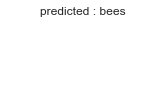

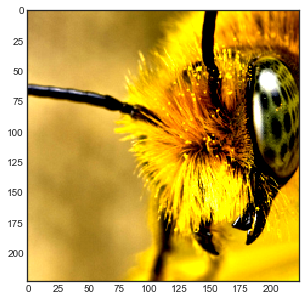

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


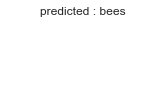

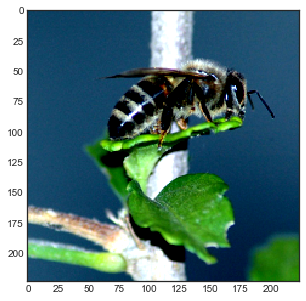

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


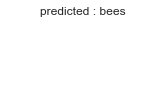

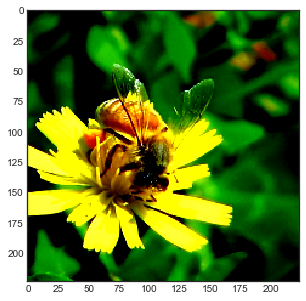

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


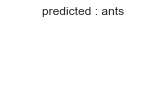

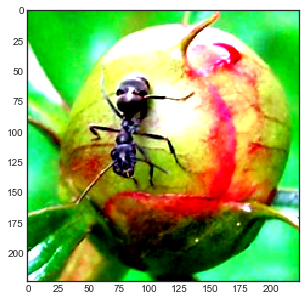

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([2.1124, 3.6986, 0.7857, 2.5995])
tensor([1, 1, 1, 1])


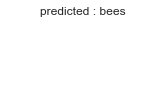

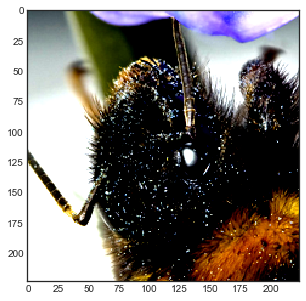

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


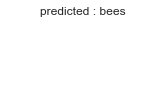

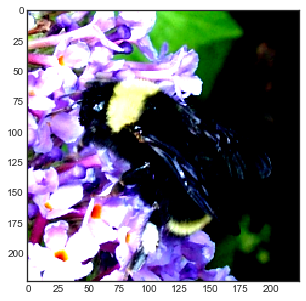

In [95]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [96]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(),lr=1e-3,momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [97]:
model_conv = train_model(model_conv,criterion,optimizer_conv,exp_lr_scheduler,num_epochs=2)

Epoch : 0/1
----------
epoch : 0 phase : train
train Loss : 0.6583 Accuracy : 0.6516
epoch : 0 phase : val
val Loss : 0.2164 Accuracy : 0.9477

Epoch : 1/1
----------
epoch : 1 phase : train
train Loss : 0.9166 Accuracy : 0.6598
epoch : 1 phase : val
val Loss : 0.1682 Accuracy : 0.9412

Training time : 1m 9s
Best Validation Accuracy : 0.947712


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([3.3603, 1.4028, 4.7764, 2.0413])
tensor([1, 1, 1, 0])


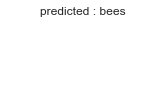

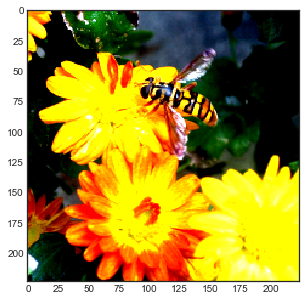

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


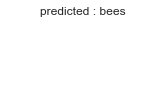

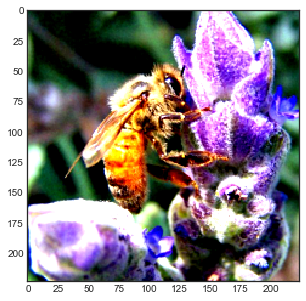

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


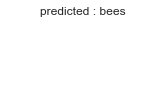

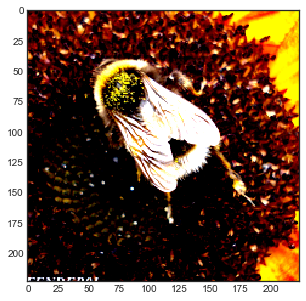

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


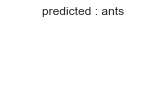

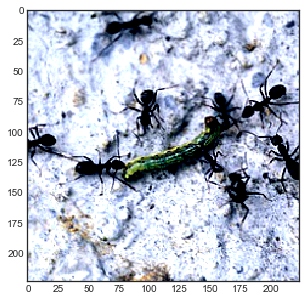

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.5515, 3.4581, 3.4221, 2.7839])
tensor([0, 1, 1, 1])


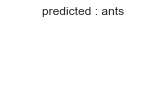

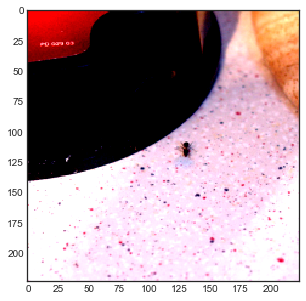

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


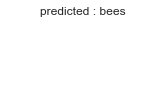

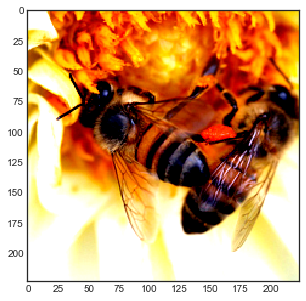

In [98]:
visualize_model(model_conv)